<a href="https://colab.research.google.com/github/victor-armegioiu/Bayesian-Neural-Nets---Stein-Variational-Gradient-Descent/blob/main/Bayesian_Neural_Nets_with_SVGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Bayesian Neural Nets with Stein Variational Gradient Descent

Citation:
*Qiang Liu and Dilin Wang. Stein Variational Gradient Descent (SVGD): A General Purpose Bayesian Inference Algorithm. NIPS, 2016.*



In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

The `SVGDOptimizer.Optimize()` method will treat a bunch of neural nets as particles, via flattening their variables and corresponding log-likelihood gradients. The overall objective is to maximize the log-likelihood of the data under the ensemble of particles, and ensure that kernelized distance between them is maximized - this ensures that we maintain diversity between the particles, and drives the particles away from collapsing to the $\text{MAP}$ estimate.

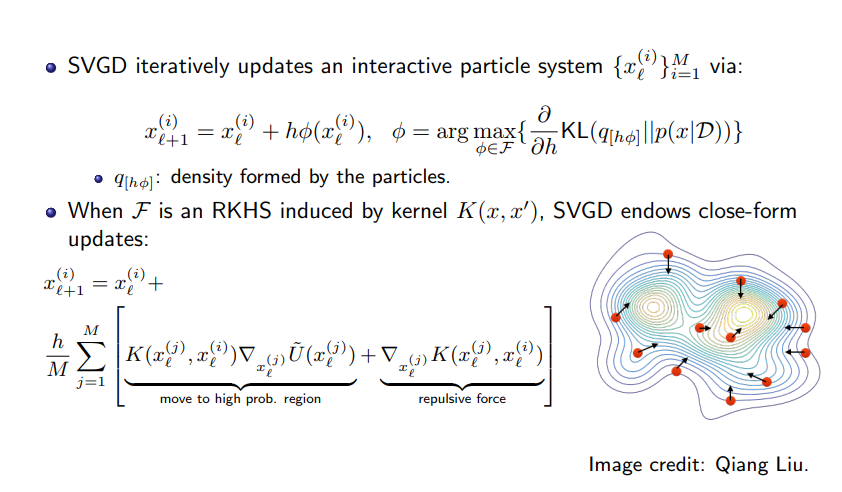

In [2]:
class SVGDOptimizer(object):
  def __init__(self, grads_list, vars_list, optimizer, median_heuristic=True):
      self.grads_list = grads_list
      self.vars_list = vars_list
      self.optimizer = optimizer
      self.num_particles = len(vars_list)
      self.median_heuristic = median_heuristic

  @staticmethod
  def GetKernel(flatvars_list, median_heuristic=True):
      stacked_vars = tf.stack(flatvars_list)
      norm = tf.reduce_sum(stacked_vars * stacked_vars, 1)
      norm = tf.reshape(norm, [-1, 1])
      pairwise_dists = (
          norm - 2 * 
          tf.matmul(stacked_vars, tf.transpose(stacked_vars)) +
          tf.transpose(norm))

      # For median in TensorFlow, I use the following reference:
      # https://stackoverflow.com/questions/43824665/tensorflow-median-value
      def _percentile(x, interpolation):
          return tfp.stats.percentile(x, 50.0, interpolation=interpolation)

      if median_heuristic:
          median = (_percentile(pairwise_dists, 'lower')
            + _percentile(pairwise_dists, 'higher')) / 2.
          median = tf.cast(median, tf.float32)
          h = tf.sqrt(0.5 * median / tf.math.log(len(flatvars_list) + 1.))

      if len(flatvars_list) == 1:
          h = 1.

      # Kernel computation and distance derivatives with respect to the
      # particles.
      Kxy = tf.exp(-pairwise_dists / h ** 2 / 2)
      dxkxy = -tf.matmul(Kxy, stacked_vars)
      sumkxy = tf.math.reduce_sum(Kxy, axis=1, keepdims=True)
      dxkxy = (dxkxy + stacked_vars * sumkxy) / tf.pow(h, 2)
      return Kxy, dxkxy

  def Optimize(self):
      flatgrads_list, flatvars_list = [], []

      for grads, vars in zip(self.grads_list, self.vars_list):
          flatgrads, flatvars = self.flatten_grads_and_vars(grads, vars)
          flatgrads_list.append(flatgrads)
          flatvars_list.append(flatvars)

      Kxy, dxkxy = self.GetKernel(flatvars_list, self.median_heuristic)
      stacked_grads = tf.stack(flatgrads_list)
      stacked_grads = (tf.matmul(Kxy, stacked_grads) + dxkxy)
      stacked_grads /= self.num_particles
      flatgrads_list = tf.unstack(stacked_grads, self.num_particles)

      # Reshape gradients for each particle in correct form.
      grads_list = []
      for flatgrads, vars in zip(flatgrads_list, self.vars_list):
          start = 0
          grads = []
          for var in vars:
              shape = self.var_shape(var)
              size = int(np.prod(shape))
              end = start + size
              grads.append(tf.reshape(flatgrads[start:end], shape))
              start = end
          grads_list.append(grads)

      for grads, vars in zip(grads_list, self.vars_list):
          self.optimizer.apply_gradients(
              [(-g, v) for g, v in zip(grads, vars)])

  def flatten_grads_and_vars(self, grads, vars):
      """Flatten gradients and variables.
      (from openai/baselines/common/tf_util.py)
      :param grads: list of gradients
      :param vars: list of variables
      :return: two lists of flattened gradients and varaibles
      """
      flatgrads = tf.concat(axis=0, values=[
          tf.reshape(grad if grad is not None else tf.zeros_like(var), [self.num_elements(var)])
          for (var, grad) in zip(vars, grads)])
      flatvars = tf.concat(axis=0, values=[
          tf.reshape(var, [self.num_elements(var)])
          for var in vars])
      return flatgrads, flatvars

  def num_elements(self, var):
      return int(np.prod(self.var_shape(var)))

  @staticmethod
  def var_shape(var):
      out = var.get_shape().as_list()
      assert all(isinstance(a, int) for a in out), \
          'shape function assumes that shape is fully known'
      return out

In [3]:
# An ensemble of these models will represent our set of particles.
def GetLinearModel():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(5, input_shape=(1,), activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  return model

In [51]:
# Some synthetic play data.
x = np.random.randn(50)[:, None]
y = np.sin(x * 5) + 2
x.shape, y.shape

((50, 1), (50, 1))

In [52]:
n_particles = 10
particles = [GetLinearModel() for _ in range(n_particles)]

optimizer = tf.keras.optimizers.Adam(0.01)
criterion = tf.keras.losses.MeanSquaredError()
n_iter = 500

for iter in range(n_iter):
  with tf.GradientTape(persistent=True) as g:
    predictions = tf.stack([particle(x) for particle in particles])
    predictions = tf.reduce_mean(predictions, axis=0)
    log_likelihood = -criterion(predictions, y)

  grads_list = []
  vars_list = []

  for particle in particles:
    grads = g.gradient(log_likelihood, particle.trainable_variables)
    grads_list.append(grads)
    vars_list.append(particle.trainable_variables)

  # Gradient ascent for log likelihood and SVGD kernel repulsive forces.
  svgd_optimizer = SVGDOptimizer(grads_list, vars_list, optimizer)
  svgd_optimizer.Optimize()

  if iter % 50 == 0:
    print('Epoch [%d] likelihood: [%f]' % (iter, log_likelihood.numpy(),))

Epoch [0] likelihood: [-4.426420]
Epoch [50] likelihood: [-0.507106]
Epoch [100] likelihood: [-0.366471]
Epoch [150] likelihood: [-0.209417]
Epoch [200] likelihood: [-0.111352]
Epoch [250] likelihood: [-0.074639]
Epoch [300] likelihood: [-0.056996]
Epoch [350] likelihood: [-0.045669]
Epoch [400] likelihood: [-0.033329]
Epoch [450] likelihood: [-0.019907]


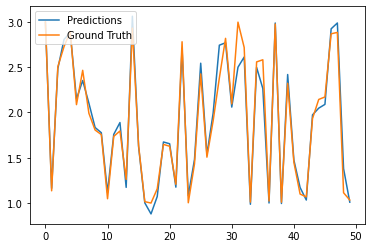

In [53]:
from matplotlib import pyplot as plt

x = np.random.randn(50)[:, None]
y = np.sin(x * 5) + 2

predictions = tf.stack([particle(x) for particle in particles])
predictions = tf.reduce_mean(predictions, axis=0)

plt.plot(predictions)
plt.plot(y)
plt.legend(['Predictions', 'Ground Truth'], loc='upper left')

plt.show()

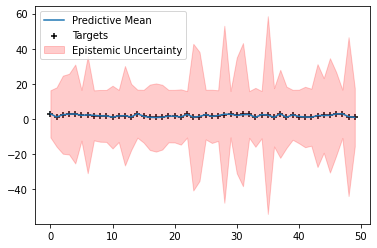

In [55]:
predictions = tf.stack([particle(x) for particle in particles])
mean_predictions = tf.reduce_mean(predictions, axis=0).numpy().squeeze(1)
predictions_std = np.std(predictions.numpy(), axis=0).squeeze(1)

plt.plot(mean_predictions, label='Predictive Mean')
plt.scatter(range(0, len(y)), y,
            label='Targets', marker='+', color='black')

# Two-sigma confidence interval.
plt.fill_between(range(0, len(y)),
                 mean_predictions - 2 * predictions_std,
                 mean_predictions + 2 * predictions_std,
                 color='red', alpha=0.2, label='Epistemic Uncertainty')

plt.legend(loc='upper left')
plt.show()